In [1]:
import numpy as np
import pandas as pd
from datasets import DatasetDict, Dataset, Image, load_dataset
from diffusers import StableDiffusionPipeline
import torch

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.0+cu121 with CUDA 1201 (you have 2.1.0+cu118)
    Python  3.10.13 (you have 3.10.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


In [2]:
data_path = '/data/datasets/'

In [23]:
df_train = pd.read_pickle(data_path + 'AffectNet/df_train.pkl')
df_val = pd.read_pickle(data_path + 'AffectNet/df_val.pkl')

In [16]:
df_train.head()

,x_col,y_col
0,data/AffectNet/train_set/images/329544.jpg,Happiness
1,data/AffectNet/train_set/images/9733.jpg,Happiness
2,data/AffectNet/train_set/images/110369.jpg,Neutral
3,data/AffectNet/train_set/images/407390.jpg,Anger
4,data/AffectNet/train_set/images/161590.jpg,Neutral


# Data Preprocessing
Add captions to photos, based upon the labels

In [24]:
# map labels to text
mapping = {
    'Happiness': 'a happy',
    'Sadness': 'a sad',
    'Surprise': 'a surprised',
    'Fear': 'a fearful',
    'Disgust': 'a disgusted',
    'Anger': 'an angry',
    'Neutral': 'a neutral',
    'Contempt': 'a contemptuous'
}
# transform y_col to text with label in it
df_train['text'] = df_train['y_col'].apply(lambda x: f'A picture of a face with {mapping[x]} expression')
df_val['text'] = df_val['y_col'].apply(lambda x: f'A picture of a face with {mapping[x]} expression')

In [18]:
df_train.head()

,x_col,y_col,text
0,data/AffectNet/train_set/images/329544.jpg,Happiness,A picture of a face with a happy expression
1,data/AffectNet/train_set/images/9733.jpg,Happiness,A picture of a face with a happy expression
2,data/AffectNet/train_set/images/110369.jpg,Neutral,A picture of a face with a neutral expression
3,data/AffectNet/train_set/images/407390.jpg,Anger,A picture of a face with an angry expression
4,data/AffectNet/train_set/images/161590.jpg,Neutral,A picture of a face with a neutral expression


In [19]:
# rename x_col to image and drop y_col
df_train = df_train.rename(columns={'x_col': 'image'})
df_train = df_train.drop(columns=['y_col'])

df_val = df_val.rename(columns={'x_col': 'image'})
df_val = df_val.drop(columns=['y_col'])

In [26]:
# adjust data path by replacing data with /data/datasets/
df_train['image'] = df_train['image'].apply(lambda x: x.replace('data', '/data/datasets'))
df_val['image'] = df_val['image'].apply(lambda x: x.replace('data', '/data/datasets'))

In [27]:
df_train.head()

,image,text
0,/data/datasets/AffectNet/train_set/images/3295...,A picture of a face with a happy expression
1,/data/datasets/AffectNet/train_set/images/9733...,A picture of a face with a happy expression
2,/data/datasets/AffectNet/train_set/images/1103...,A picture of a face with a neutral expression
3,/data/datasets/AffectNet/train_set/images/4073...,A picture of a face with an angry expression
4,/data/datasets/AffectNet/train_set/images/1615...,A picture of a face with a neutral expression


In [34]:
# combine train and val
df_train = pd.concat([df_train, df_val])
df_train.reset_index(drop=True, inplace=True)
# create dataset dict from pandas dataframe
train = Dataset.from_pandas(df_train).cast_column("image", Image())

## Create Dataset Object for Training

In [35]:
dataset = DatasetDict({'train': train})
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 295649
    })
})

In [36]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'text': 'A picture of a face with a happy expression'}

In [37]:
# save dataset for later use
dataset.save_to_disk(data_path + 'AffectNet/dataset')

Saving the dataset (0/5 shards):   0%|          | 0/295649 [00:00<?, ? examples/s]

In [44]:
dataset = load_dataset(data_path + 'AffectNet/dataset')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/home/jthomas/Documents/AAI521/venv/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


## After Training, Compare v1 and v2
Training was done using train_text_to_image_lora.py for one epoch, using:

```
export MODEL_NAME="stabilityai/stable-diffusion-2-1"
export dataset_name="/data/datasets/AffectNet/dataset"

accelerate launch extra/train_text_to_image_lora.py \
--pretrained_model_name_or_path=$MODEL_NAME \
--dataset_name=$dataset_name \  
--resolution=768 --center_crop --random_flip --train_batch_size=1  \ 
--gradient_accumulation_steps=16   --gradient_checkpointing \
--mixed_precision="bf16"    --learning_rate=1e-04   --max_grad_norm=1 \
--lr_scheduler="constant" --lr_warmup_steps=0 \
--output_dir="/data/models/affectnet-diffusion-v2" --report_to="wandb" \
--validation_prompt="an angry man" --checkpointing_steps=500000 --num_train_epochs=1
```

In [3]:
model_path = '/data/models/affectnet-diffusion'
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe.unet.load_attn_procs(model_path)

pipe.to('cuda')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.23.0",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [4]:
model_path_2 = '/data/models/affectnet-diffusion-v2'
pipe_2 = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16)
pipe_2.unet.load_attn_procs(model_path_2)

pipe_2.to('cuda')

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.23.0",
  "_name_or_path": "stabilityai/stable-diffusion-2-1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
prompt = "A picture of a man with a angry expression"
image_1 = pipe(prompt, num_inference_steps=30, guidance_scale=7.5).images[0]
image_2 = pipe_2(prompt, num_inference_steps=30, guidance_scale=7.5).images[0]

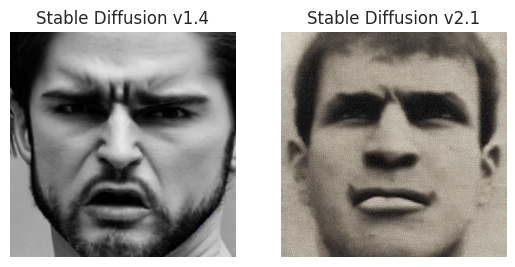

In [13]:
# display both images
import matplotlib.pyplot as plt
def show_images(img1, img2, filename):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img1)
    ax1.set_title('Stable Diffusion v1.4')
    ax2.imshow(img2)
    ax2.set_title('Stable Diffusion v2.1')
    # remove axis
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    fig.savefig(filename)
    
show_images(image_1, image_2, 'angry_comparison.png')

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

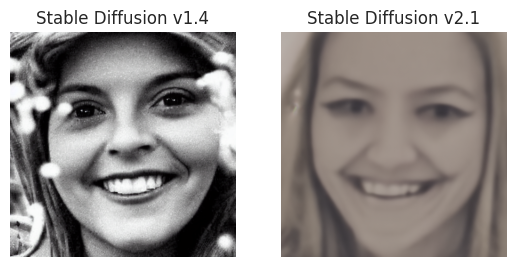

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

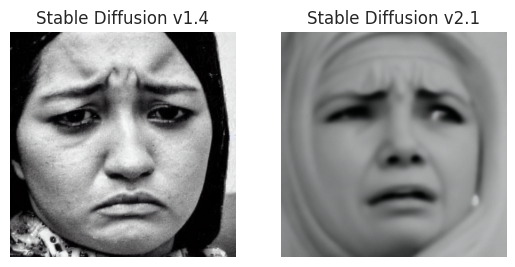

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

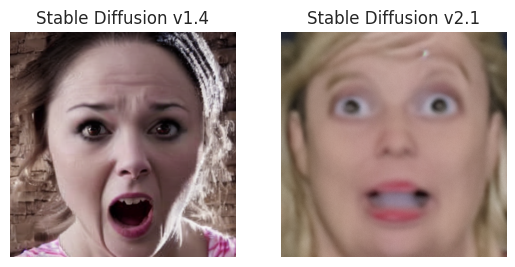

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

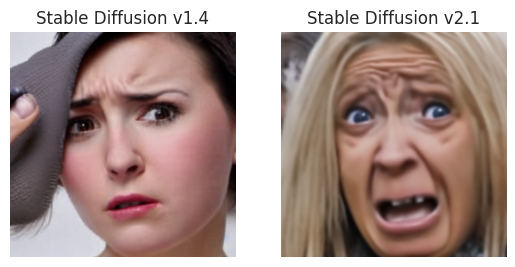

  0%|          | 0/30 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/30 [00:00<?, ?it/s]

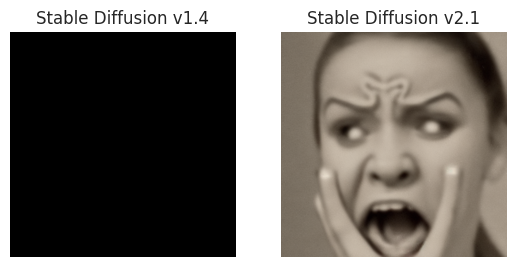

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

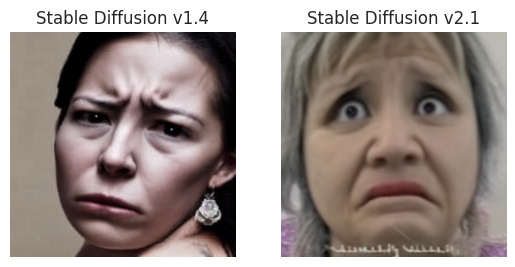

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

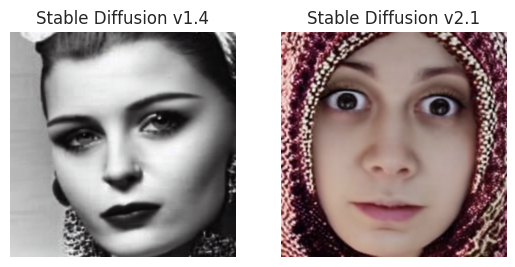

  0%|          | 0/30 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/30 [00:00<?, ?it/s]

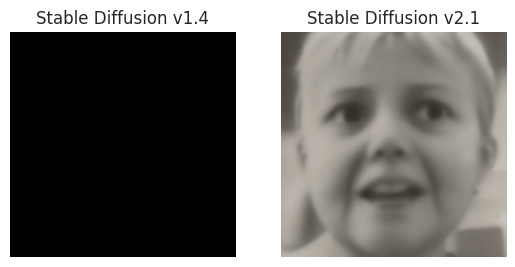

In [36]:
options = ['a man', 'a woman', 'a child']
for value in mapping.values():
    subject = np.choose(1, options)
    prompt = 'A photo of ' + subject + ' with ' + value + ' expression on their face'
    image1 = pipe(prompt, num_inference_steps=30, guidance_scale=7.5).images[0]
    image2 = pipe_2(prompt, num_inference_steps=30, guidance_scale=7.5).images[0]
    show_images(image1, image2, f'{value.split()[-1]}_comparison.png')